# Lab assignment №1, part 2

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the second part of the assignment. First and third parts are waiting for you in the same directory.*__

## Part 2. Data preprocessing, model training and evaluation.

### 1. Reading the data
Today we work with the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), describing different cars for multiclass ($k=4$) classification problem. The data is available below.

In [ ]:
# ! pip install scikit-plot -q

In [1]:
# If on colab, uncomment the following lines

# ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/lab01_ml_pipeline/car_data.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import catboost as ctb
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 19) (846,)
(549, 19) (549,) (297, 19) (297,)


To get some insights about the dataset, `pandas` might be used. The `train` part is transformed to `pd.DataFrame` below.

In [2]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,406,80,38,64,130,59,8,134,51,18,126,152,259,135,76,1,23,179,188
1,166,92,36,78,165,57,8,153,43,19,128,169,349,124,60,4,19,203,211
2,505,115,53,100,205,64,11,220,30,25,166,229,710,214,71,21,11,189,199
3,326,106,49,96,201,61,10,181,36,21,158,197,494,180,62,19,15,202,209
4,732,85,45,73,167,69,8,143,46,18,148,173,307,176,71,2,0,190,199
5,388,94,47,85,333,138,49,155,43,19,155,320,354,187,135,12,9,188,196
6,362,95,47,81,176,59,7,168,39,20,152,196,425,185,67,4,4,191,198
7,300,106,53,98,193,60,10,215,31,24,169,224,681,218,73,8,21,188,197
8,780,109,47,96,206,64,9,198,33,23,150,219,586,191,70,4,13,190,198
9,92,104,52,100,191,59,9,197,33,23,158,218,583,234,70,10,10,191,198


Methods `describe` and `info` deliver some useful information.

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       549 non-null    int64
 1   1       549 non-null    int64
 2   2       549 non-null    int64
 3   3       549 non-null    int64
 4   4       549 non-null    int64
 5   5       549 non-null    int64
 6   6       549 non-null    int64
 7   7       549 non-null    int64
 8   8       549 non-null    int64
 9   9       549 non-null    int64
 10  10      549 non-null    int64
 11  11      549 non-null    int64
 12  12      549 non-null    int64
 13  13      549 non-null    int64
 14  14      549 non-null    int64
 15  15      549 non-null    int64
 16  16      549 non-null    int64
 17  17      549 non-null    int64
 18  18      549 non-null    int64
dtypes: int64(19)
memory usage: 81.6 KB


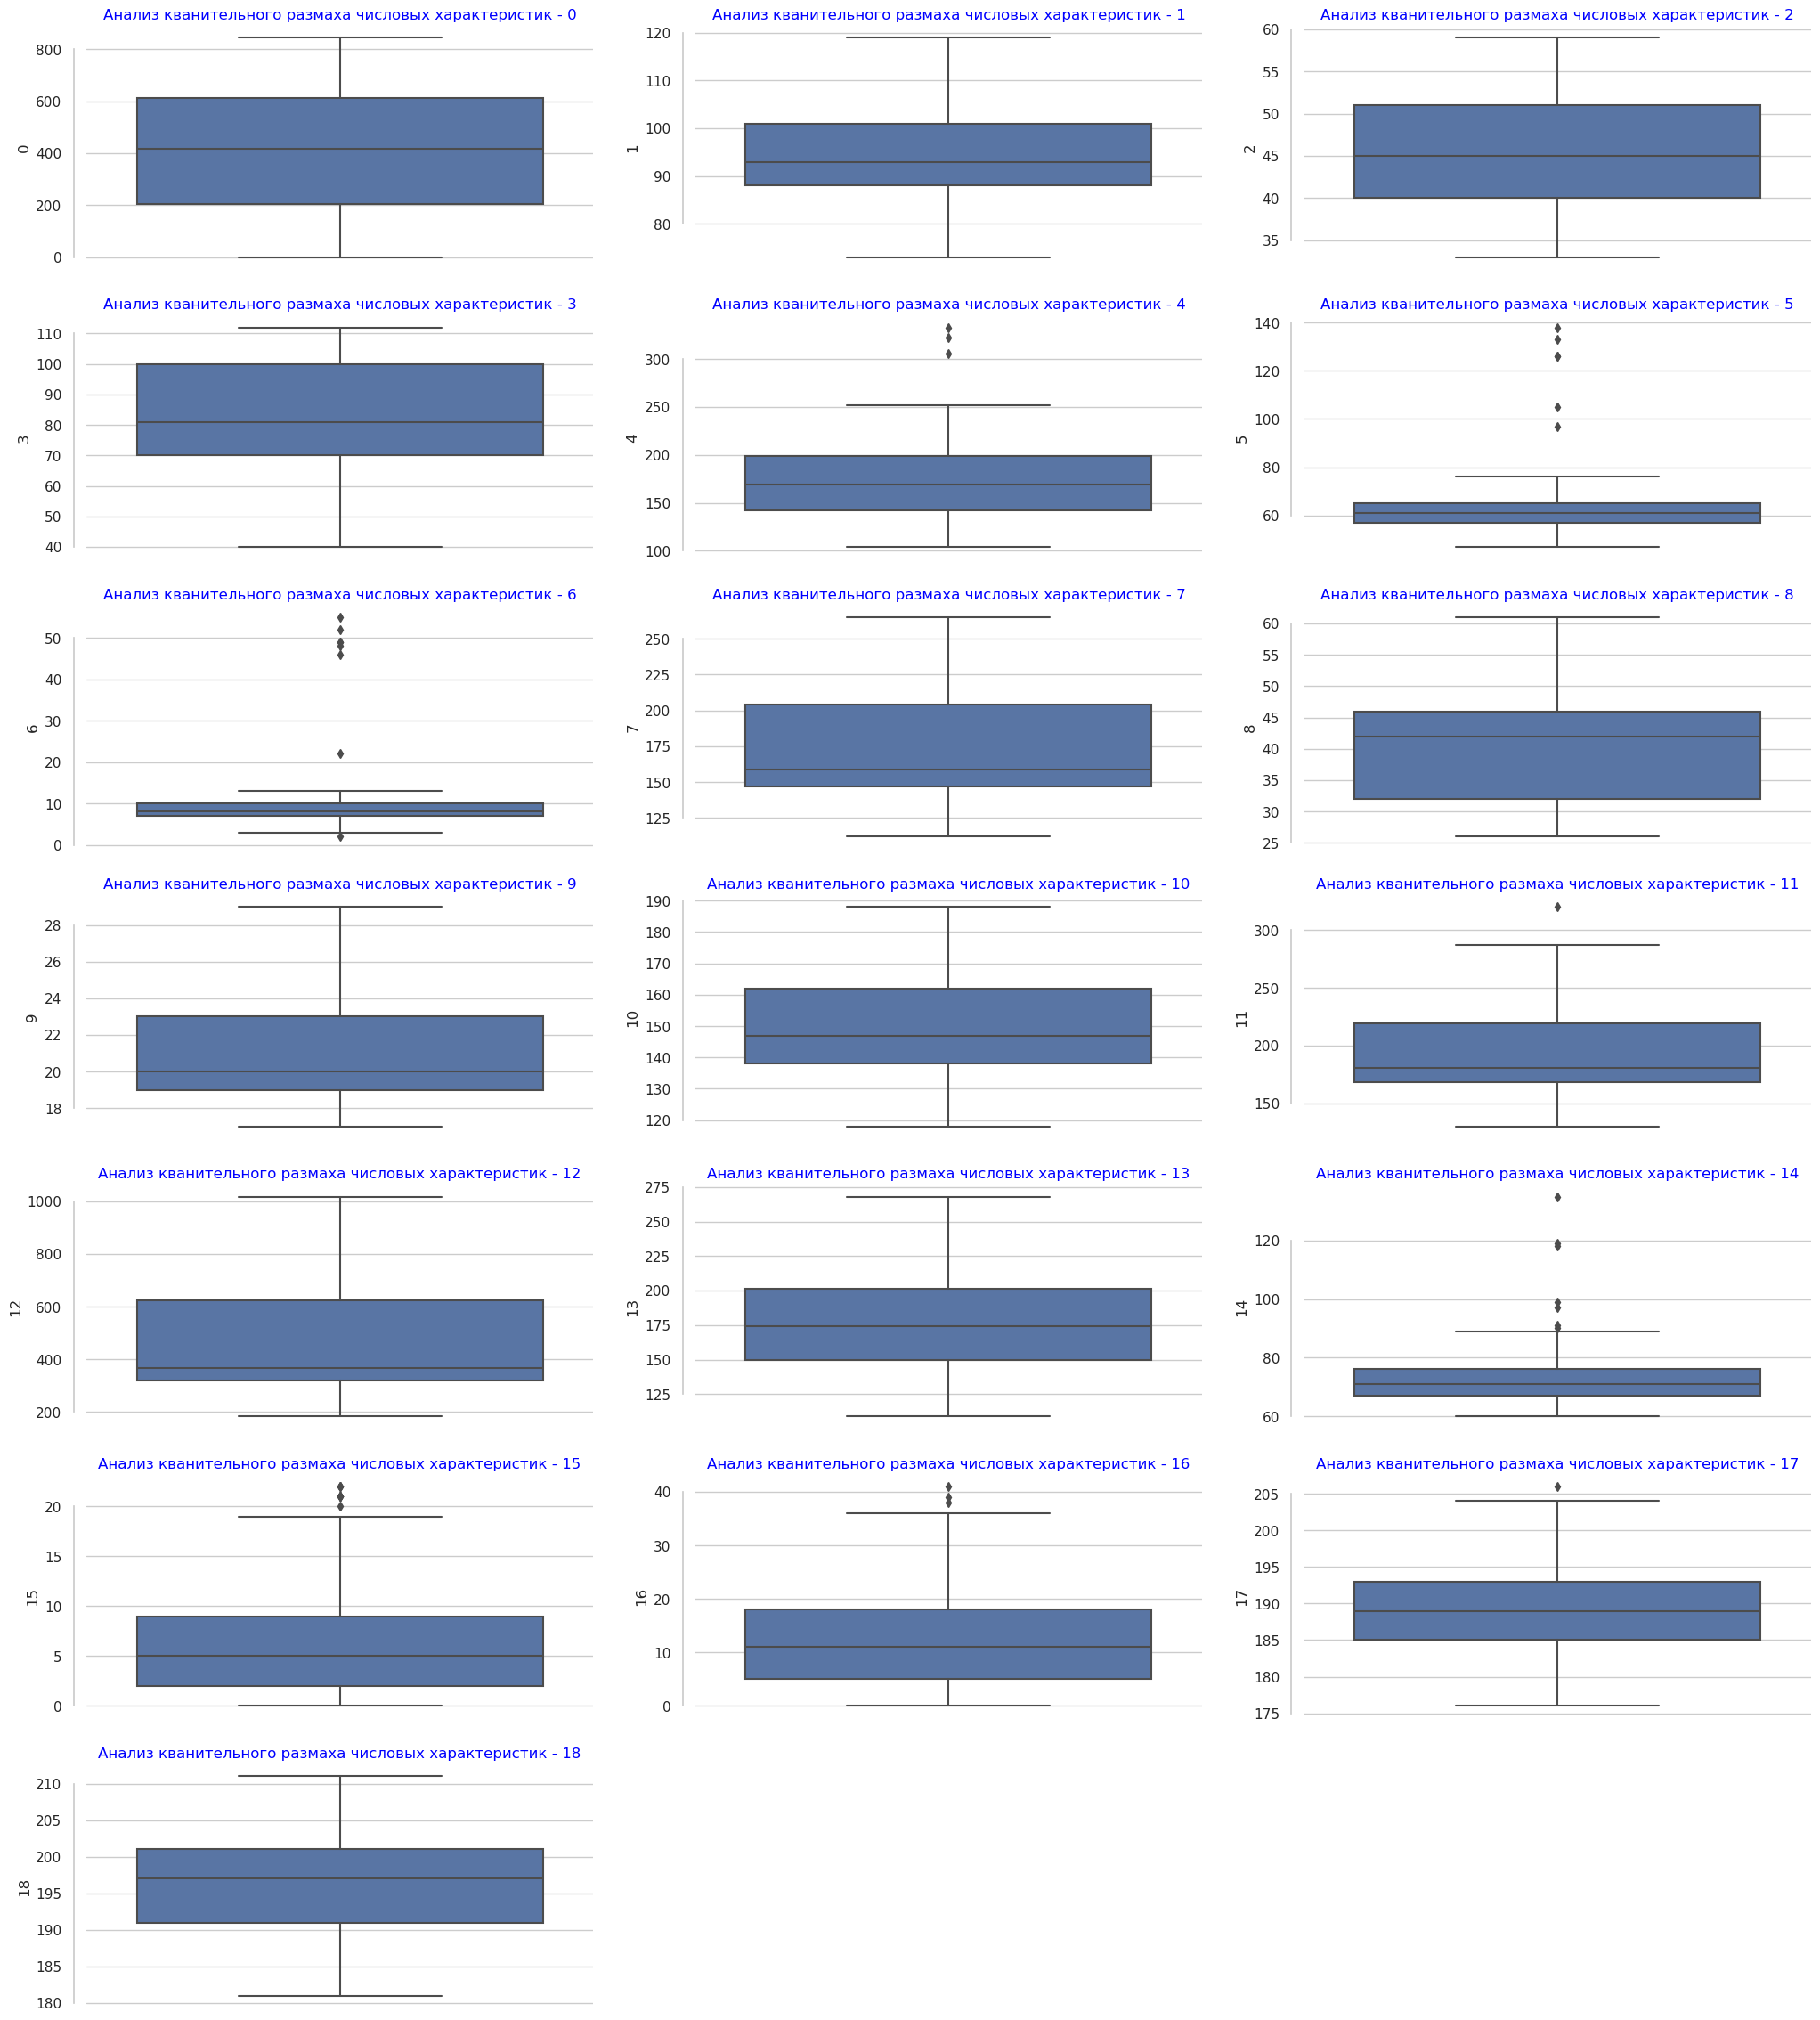

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(25,50))

for ind, col_name in enumerate(X_train_pd.columns):
  plt.subplot(12,3,ind+1)
  ax=sns.boxplot(
            y=col_name,
            data=X_train_pd,
            dodge=True

            )
  #sns.move_legend(ax, "lower left", bbox_to_anchor=(0.87, -0.1));
  plt.title("Анализ кванительного размаха числовых характеристик - "+str(col_name), fontdict={'fontsize':12, 'fontweight':'medium', 'color':'blue'})
sns.despine(offset=10, trim=True)

В данных присутствует достаточное количество выбросов. Но пока, без понимания их природы, избавляться от них не будем. Может оказаться, что это не выбросы (ошибочные данные), а экстремальные значения какого-нибудь параметра.

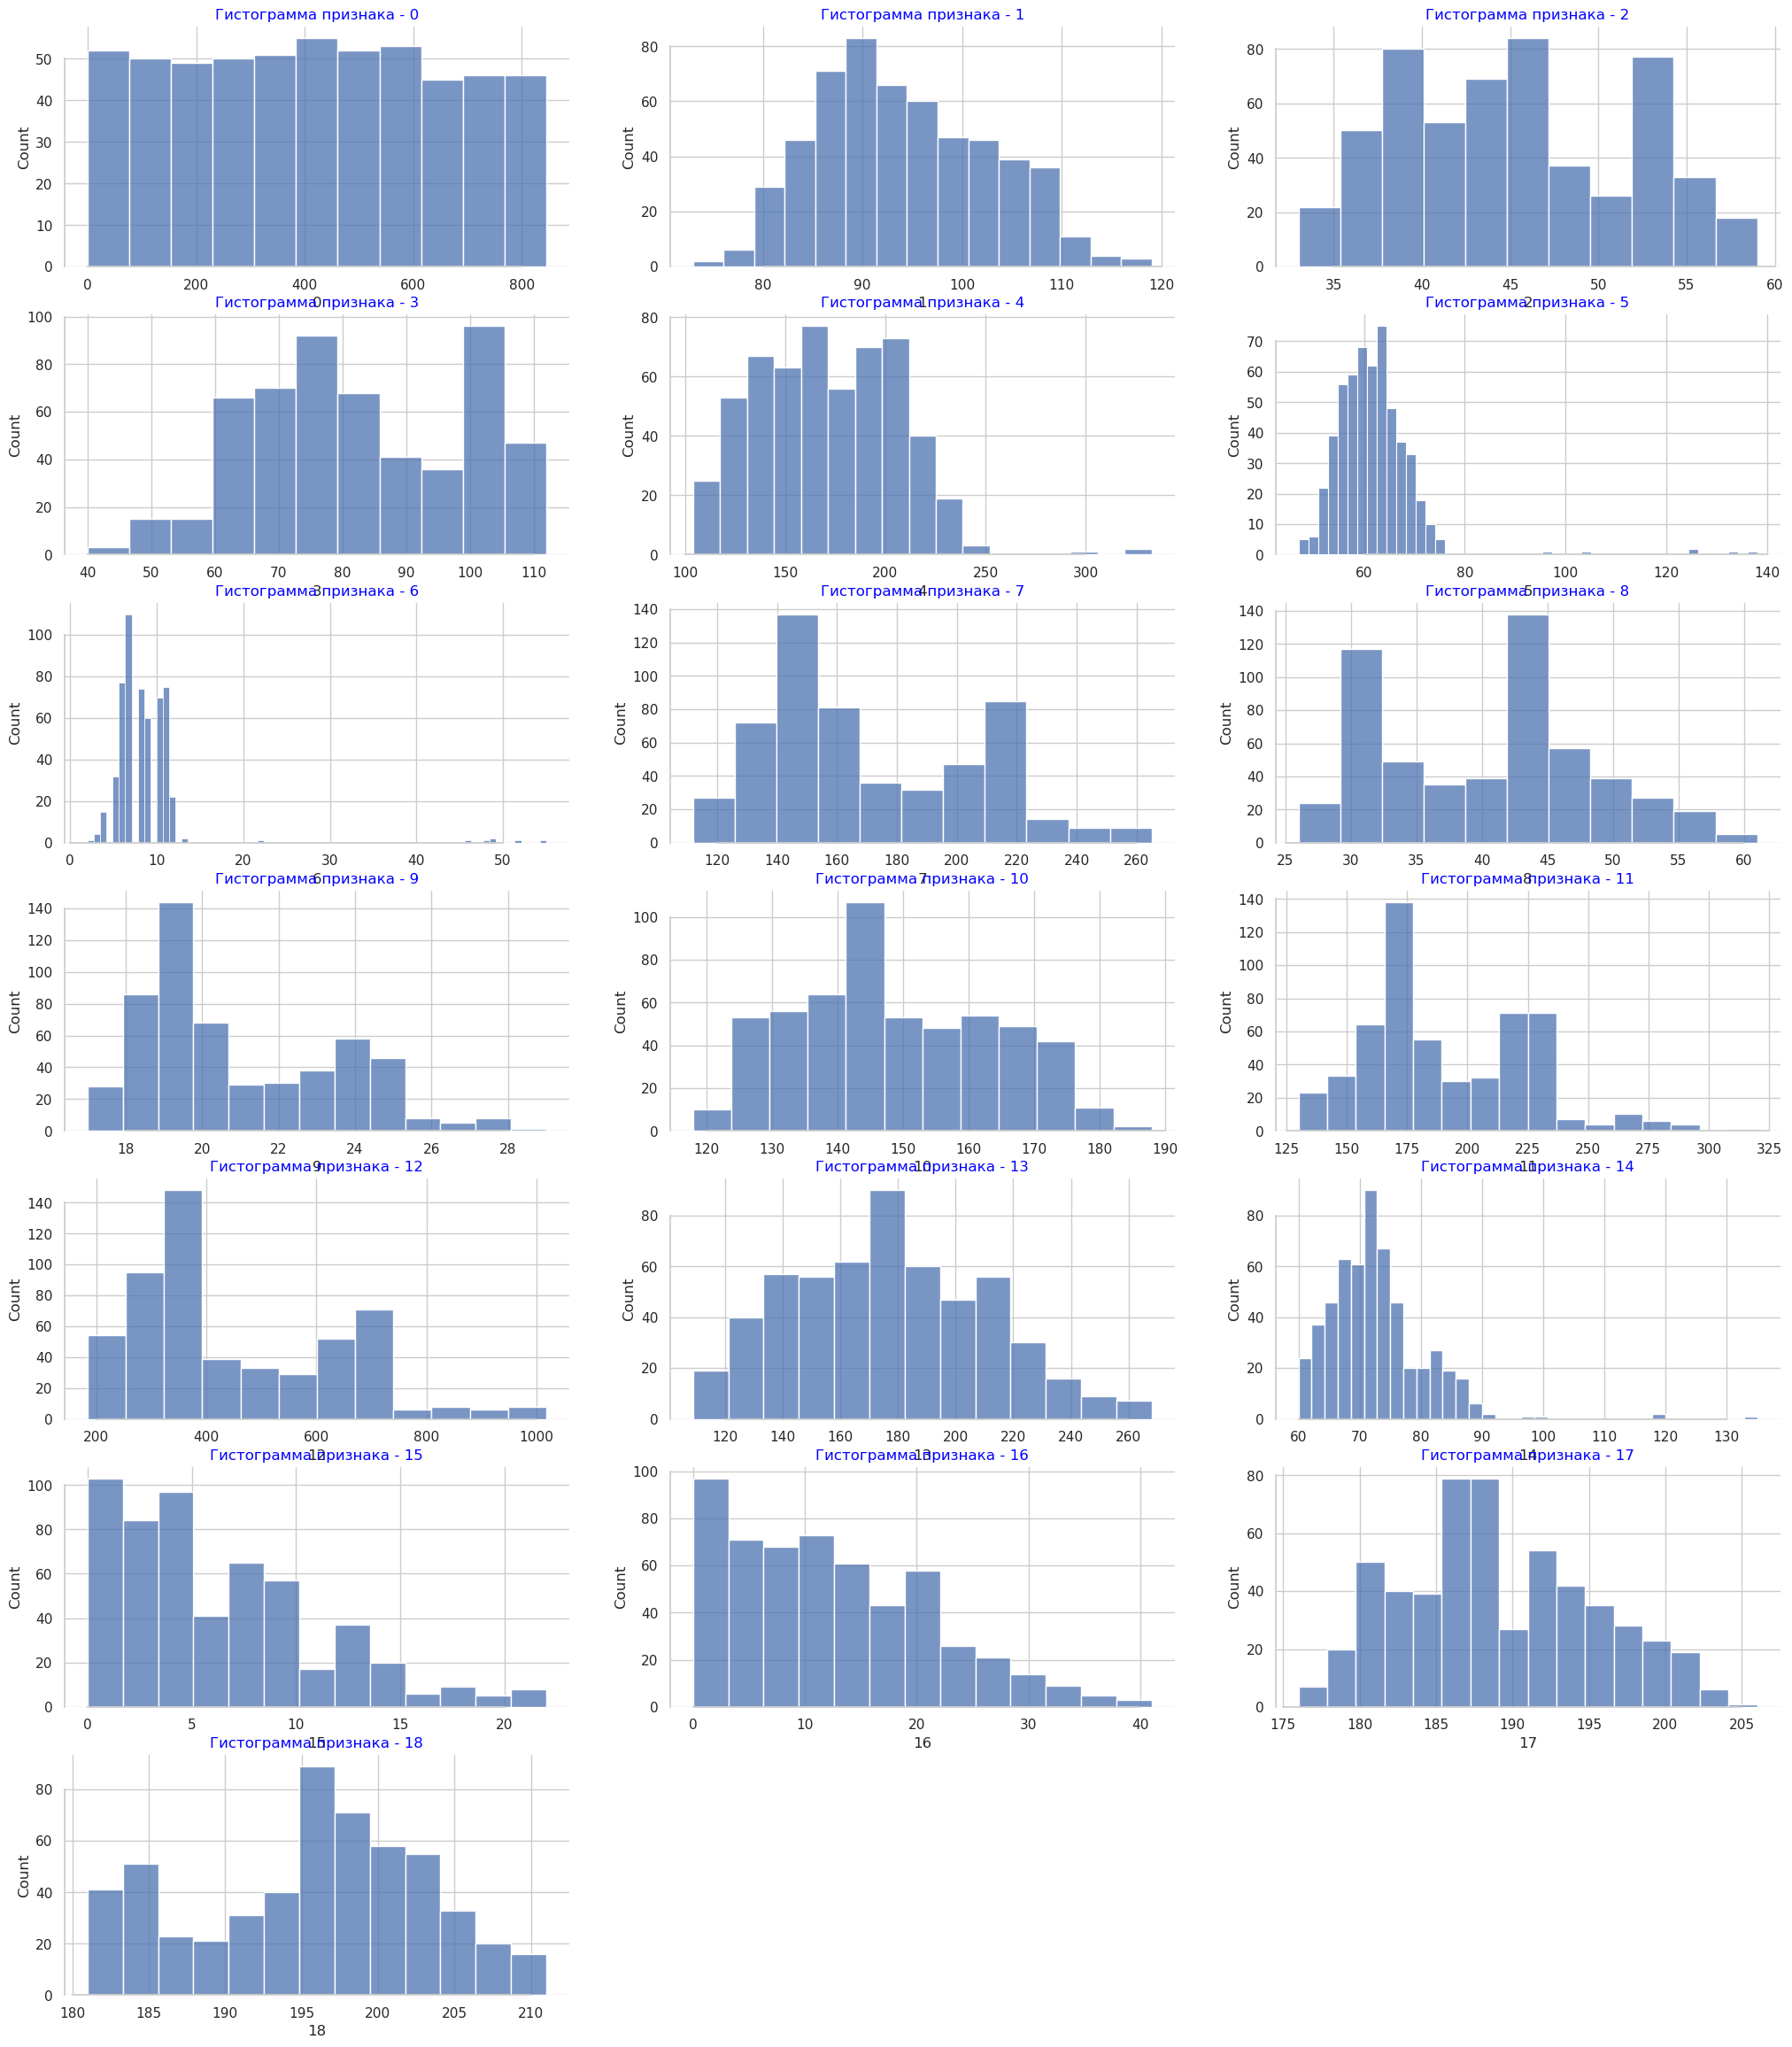

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(25,50))

for ind, col_name in enumerate(X_train_pd.columns):
    plt.subplot(12,3,ind+1).set_title(f'Гистограмма признака {col_name}')
    ax=sns.histplot(x=col_name, data=X_train_pd)


    plt.title("Гистограмма признака - "+str(col_name), fontdict={'fontsize':12, 'fontweight':'medium', 'color':'blue'})

sns.despine(offset=0, trim=True);

Text(0.5, 1.0, 'Выбросы в признаках')

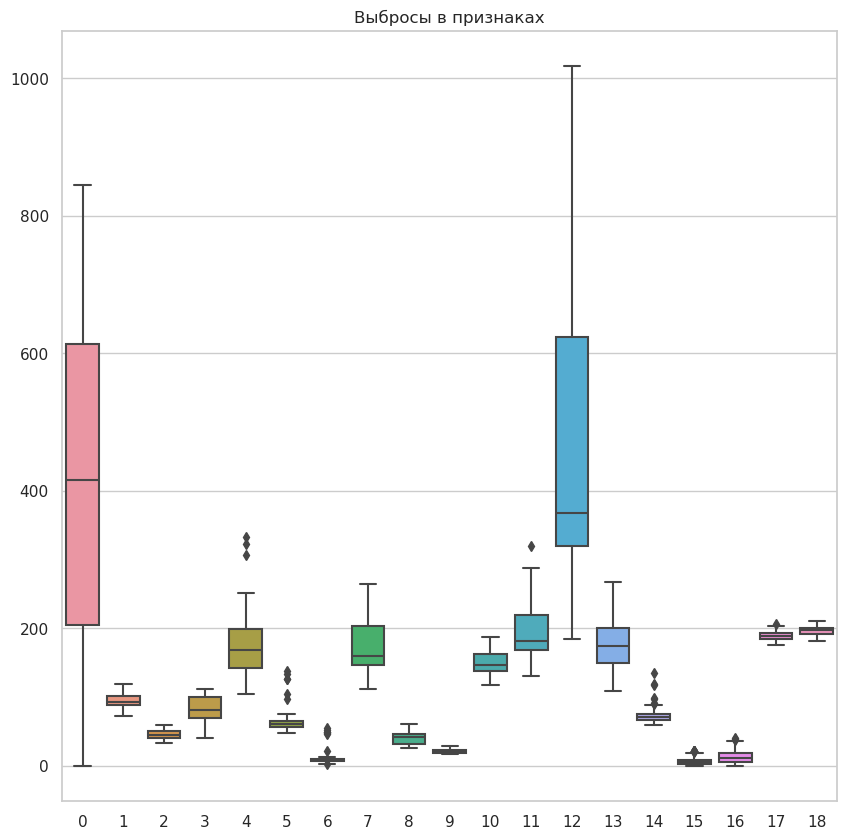

In [7]:
plt.figure(figsize=(10,10))
sns.boxplot(X_train).set_title('Выбросы в признаках')

### 2. Machine Learning pipeline
Here you are supposed to perform the desired transformations. Please, explain your results briefly after each task.


#### 2.0. Data preprocessing
* Make some transformations of the dataset (if necessary). Briefly explain the transformations


**Нормализуем признаки, логистическая регрессия требует нормализации признаков, чтобы гарантировать, что признаки вносят одинаковый вклад в модель.**

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

Text(0.5, 1.0, 'Выбросы в признаках после нормализации')

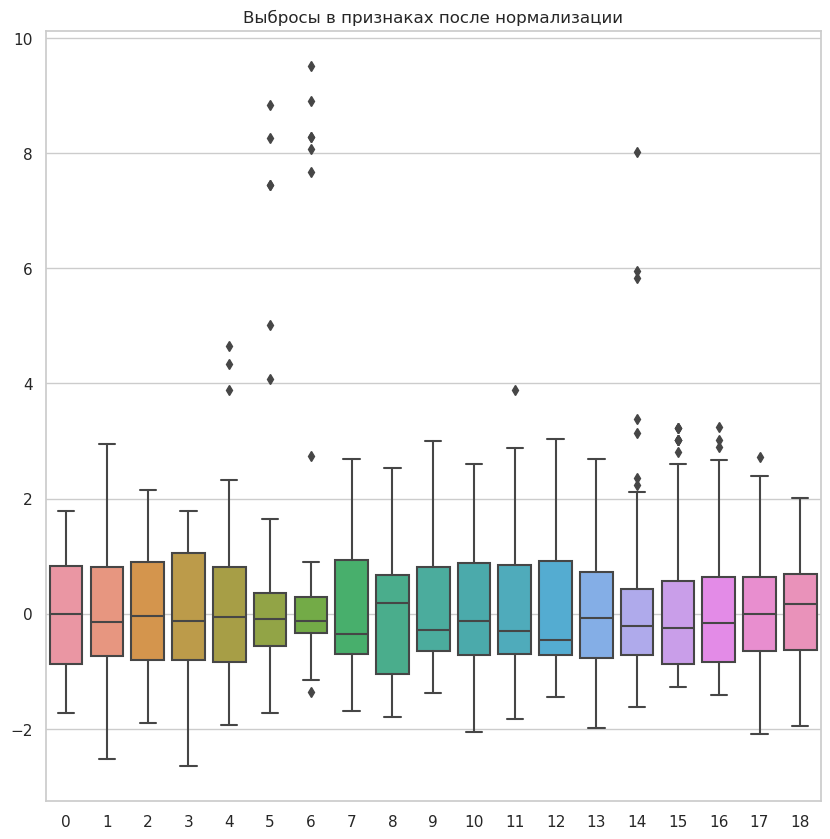

In [9]:
plt.figure(figsize=(10,10))
sns.boxplot(scaled_X_train).set_title('Выбросы в признаках после нормализации')

#### 2.1. Basic logistic regression
* Find optimal hyperparameters for logistic regression with cross-validation on the `train` data (small grid/random search is enough, no need to find the *best* parameters).

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` `tol=1e-3` and ` max_iter=500`.*

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import uniform
import scikitplot

In [11]:
SEED = 42
logistic = LogisticRegression(
    random_state = SEED,
    solver = 'saga',
    multi_class = 'multinomial',
    tol=1e-3,
    max_iter=500

    )
distributions = dict(C=uniform(loc=0, scale=100), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=SEED, cv=10)
search = clf.fit(scaled_X_train, y_train)

In [12]:
reg_params = clf.best_params_

In [13]:
search.cv_results_['params']

[{'C': 37.454011884736246, 'penalty': 'l2'},
 {'C': 18.34347898661638, 'penalty': 'l1'},
 {'C': 59.86584841970366, 'penalty': 'l2'},
 {'C': 44.583275285359115, 'penalty': 'l2'},
 {'C': 5.8083612168199465, 'penalty': 'l1'},
 {'C': 33.37086111390219, 'penalty': 'l1'},
 {'C': 70.80725777960456, 'penalty': 'l1'},
 {'C': 5.641157902710026, 'penalty': 'l1'},
 {'C': 83.24426408004217, 'penalty': 'l1'},
 {'C': 0.07787658410143283, 'penalty': 'l1'}]

На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:
Accuracy score:  0.7744107744107744
F1_score:     0.7742539191572705


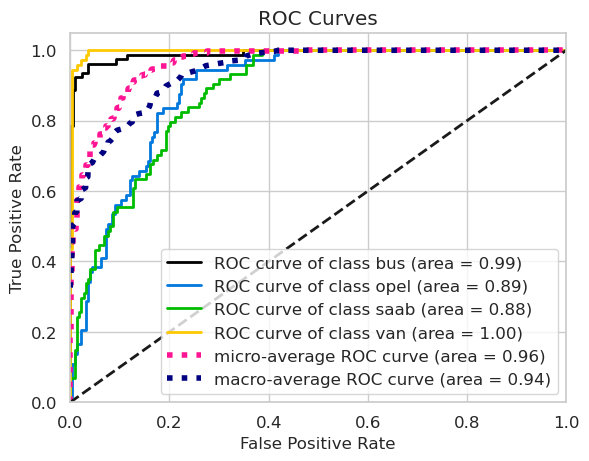

In [14]:

scaled_X_test = scaler.transform(X_test)
y_pred = search.predict(scaled_X_test)
print('На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:')
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1_score:    ", f1_score(y_test, y_pred, average = "weighted"))

scikitplot.metrics.plot_roc(y_test, search.predict_proba(scaled_X_test))
plt.show()

#### 2.2. PCA: explained variance plot
* Apply the PCA to the train part of the data. Build the explaided variance plot.

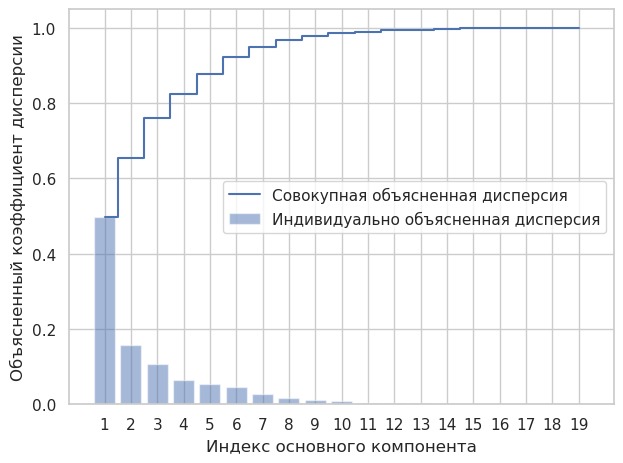

In [15]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(scaled_X_train)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(
    range(1,len(exp_var_pca)+1),
    exp_var_pca,
    alpha=0.5,
    align='center',
    label='Индивидуально объясненная дисперсия'
    )

plt.step(
    range(1,len(cum_sum_eigenvalues)+1),
    cum_sum_eigenvalues,
    where='mid',
    label='Cовокупная объясненная дисперсия'
    )

plt.xticks([*range(1, 20)])
plt.ylabel('Объясненный коэффициент дисперсии')
plt.xlabel('Индекс основного компонента')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### 2.3. PCA trasformation
* Select the appropriate number of components. Briefly explain your choice. Should you normalize the data?

*Use `fit` and `transform` methods to transform the `train` and `test` parts.*

In [16]:
n_dim = 12

pca = PCA(n_components=n_dim)
pca.fit(scaled_X_train)
pca_train = pca.transform(scaled_X_train)
pca_test = pca.transform(scaled_X_test)


**Should you normalize the data?**

Алгоритм PCA определяет направления наиболее крупных дисперсий. Поскольку дисперсия переменной измеряется в ее собственном квадрате, перед вычислением основных компонентов все переменные должны иметь среднее значение 0 и стандартное отклонение 1. В противном случае те переменные, масштаб которых больше, доминировали бы в PCA. А так мы получаем условно "облако", в то время как без масштабирования могли получать условную "сигару" (данные сильно сжаты по одному из направлений).

Для данных выберем 12 компонент, так как это количество объясняет почти 100% дисперсии данных.


**Note: From this point `sklearn` [Pipeline](https://scikit-learn.org/stable/modules/compose.html) might be useful to perform transformations on the data. Refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for more information.**

#### 2.4. Logistic regression on PCA-preprocessed data.
* Find optimal hyperparameters for logistic regression with cross-validation on the transformed by PCA `train` data.

* Estimate the model quality with `f1` and `accuracy` scores.
* Plot a ROC-curve for the trained model. For the multiclass case you might use `scikitplot` library (e.g. `scikitplot.metrics.plot_roc(test_labels, predicted_proba)`).

*Note: please, use the following hyperparameters for logistic regression: `multi_class='multinomial'`, `solver='saga'` and `tol=1e-3`*

На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:
Accuracy score:  0.7239057239057239
F1_score:     0.723935005137231


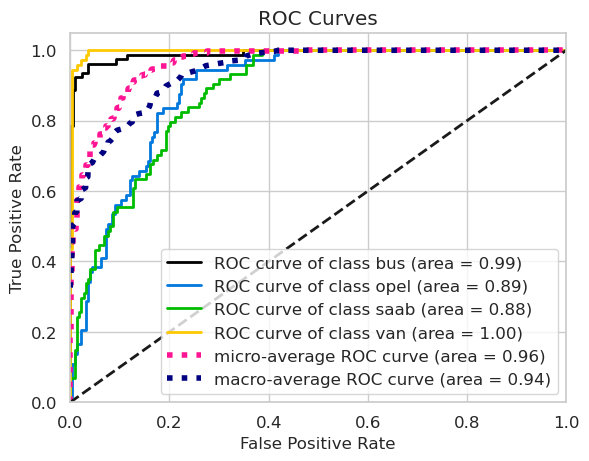

In [17]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
import random

def make_model(model=False, seed = 42):
    if model == False:
        model = 'logreg'
    n_dim = 12
    logreg = LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-3, max_iter=500)

#     return Pipeline([('logreg', logreg) ])

    SEED = 42
    if model == 'logreg':

        logistic = LogisticRegression(
                                    # random_state = SEED,
                                    solver = 'saga',
                                    multi_class = 'multinomial',
                                    tol=1e-3,
                                    max_iter=500
        )
        distributions = dict(C=uniform(loc=0, scale=10), penalty=['l2'])
        clf = RandomizedSearchCV(logistic, distributions, random_state=SEED, n_jobs=-1, cv=10, scoring = 'accuracy', n_iter=21)

        return Pipeline([
            ('sca', StandardScaler()),
            ('pca', PCA(n_components=n_dim)),
            ('model', clf)
        ])

    if model == 'desion_tree':

        tree = DecisionTreeClassifier(random_state=SEED)
        grid = {'max_depth': [*range(1, 51)]}
        clf = RandomizedSearchCV(tree, grid, random_state = SEED, n_jobs=-1, cv=10, scoring = 'accuracy', n_iter=21)

        return Pipeline([
            ('sca', StandardScaler()),
            ('pca', PCA(n_components=n_dim)),
            ('model', clf)
        ])

    if model == 'forest':

        forest = RandomForestClassifier(random_state=SEED)
        param_dist = {
            "max_depth": [*range(3, 50)],
            "n_estimators": [*range(2, 100, 5)],

            }
        clf = RandomizedSearchCV(forest, param_dist, random_state = SEED, n_jobs=-1, cv=10, scoring = 'accuracy', n_iter=21)

        return Pipeline([
            ('sca', StandardScaler()),
            ('pca', PCA(n_components=n_dim)),
            ('model', clf)
        ])

model = make_model()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:')
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1_score:    ", f1_score(y_test, y_pred, average = "weighted"))

scikitplot.metrics.plot_roc(y_test, search.predict_proba(scaled_X_test))
plt.show()

#### 2.5. Decision tree
* Now train a desicion tree on the same data. Find optimal tree depth (`max_depth`) using cross-validation.

* Measure the model quality using the same metrics you used above.

На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:
Accuracy score:  0.6161616161616161
F1_score:     0.6234362563083553
Полученная оптимальная глубина дерева:  7


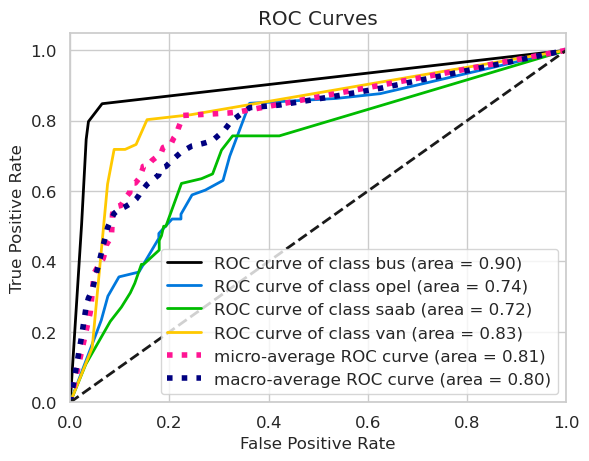

In [18]:
model_2 = make_model('desion_tree')
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print('На нормализованных данных обучаем логистическую регрессию и получаем следующие метрики качества:')
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1_score:    ", f1_score(y_test, y_pred, average = "weighted"))
print(f"Полученная оптимальная глубина дерева:  {model_2['model'].best_params_['max_depth']}")

scikitplot.metrics.plot_roc(y_test, model_2.predict_proba(X_test))
plt.show()


#### 2.6. Bagging.
Here starts the ensembling part.

First we will use the __Bagging__ approach. Build an ensemble of $N$ algorithms varying N from $N_{min}=2$ to $N_{max}=100$ (with step 5).

We will build two ensembles: of logistic regressions and of decision trees.

*Comment: each ensemble should be constructed from models of the same family, so logistic regressions should not be mixed up with decision trees.*


*Hint 1: To build a __Bagging__ ensebmle varying the ensemble size efficiently you might generate $N_{max}$ subsets of `train` data (of the same size as the original dataset) using bootstrap procedure once. Then you train a new instance of logistic regression/decision tree with optimal hyperparameters you estimated before on each subset (so you train it from scratch). Finally, to get an ensemble of $N$ models you average the $N$ out of $N_{max}$ models predictions.*

*Hint 2: sklearn might help you with this taks. Some appropriate function/class might be out there.*

* Plot `f1` and `accuracy` scores plots w.r.t. the size of the ensemble.

* Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.

* How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble?

In [19]:
from sklearn.ensemble import BaggingClassifier

In [20]:
n_estimators = [2,*range(5, 101, 5)]
bag_acc = []
bag_f1 = []
for i in n_estimators:
    tree = DecisionTreeClassifier(random_state=SEED)
    grid = {'max_depth': [*range(1, 51)]}
    tree = RandomizedSearchCV(tree, grid, random_state = SEED, n_jobs=-1, cv=10, scoring = 'accuracy')
    trees = BaggingClassifier(estimator = tree, random_state=SEED, n_estimators=i)
    trees.fit(scaled_X_train, y_train)
    y_pred = trees.predict(scaled_X_test)
    bag_acc.append(accuracy_score(y_test, y_pred))
    bag_f1.append(f1_score(y_test, y_pred, average = "weighted"))

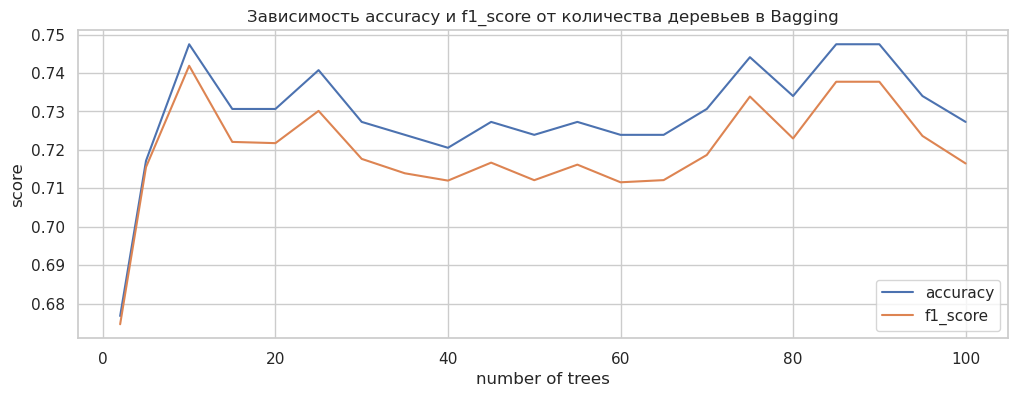

In [21]:
plt.figure(figsize=(12,4))
plt.plot(n_estimators, bag_acc, label='accuracy')
plt.plot(n_estimators, bag_f1, label='f1_score')


plt.title("Зависимость accuracy и f1_score от количества деревьев в Bagging")
plt.xlabel("number of trees")
plt.ylabel("score")
plt.legend(loc='best')
plt.show()

**Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.**

По графику видно, что при увеличении количества деревьев в ансамбле, общающая способность бэггинга возрастает, и стабилизируется примерно на 70 деревьях.

**How do you think, are the hyperparameters for the decision trees you found in 2.5 optimal for trees used in ensemble?**

Думаю оптимальные гиперпараметры для decision tree найденые ранее подходят для выполнения этой задачи, так как подобранны на всех данных тренировочных данных, а не на бутстрап выборке из них.

In [113]:
bag_2_acc = []
bag_2_f1 = []
for i in n_estimators:
    logreg = LogisticRegression(
                                    solver = 'saga',
                                    multi_class = 'multinomial',
                                    tol=1e-3,
                                    max_iter=500
                                )
    logreg.set_params(**reg_params)
    bag_2 = BaggingClassifier(estimator = logreg, random_state=SEED, n_estimators=i)
    bag_2.fit(scaled_X_train, y_train)
    y_pred = bag_2.predict(scaled_X_test)
    bag_2_acc.append(accuracy_score(y_test, y_pred))
    bag_2_f1.append(f1_score(y_test, y_pred, average = "weighted"))

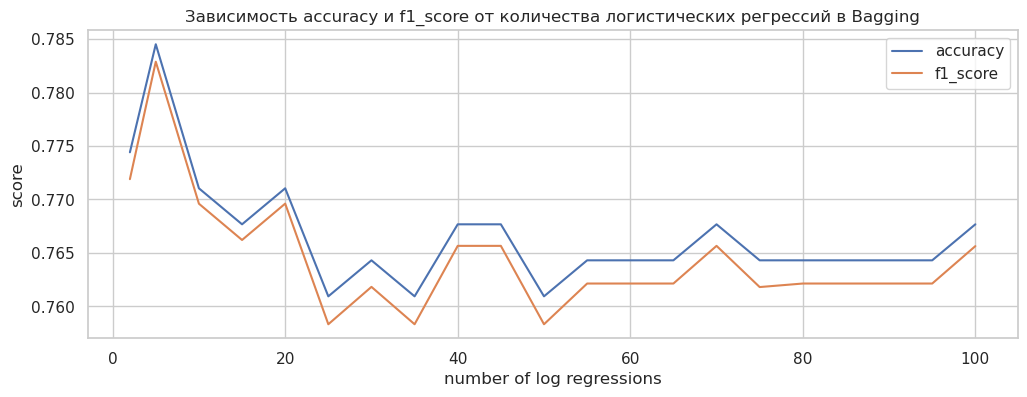

In [114]:
plt.figure(figsize=(12,4))
plt.plot(n_estimators, bag_2_acc, label='accuracy')
plt.plot(n_estimators, bag_2_f1, label='f1_score')


plt.title("Зависимость accuracy и f1_score от количества логистических регрессий в Bagging")
plt.xlabel("number of log regressions")
plt.ylabel("score")
plt.legend(loc='best')
plt.show()

**Briefly analyse the plot. What is the optimal number of algorithms? Explain your answer.**

По графику видно, что при увеличении количества деревьев в ансамбле, обощающая способность алгоритма тоже возрастает хотя и ведет себя менее стабильно, показывая максимальные метрики на промежутке с ансамблем от 30 до 70 классификаторов.

#### 2.7. Random Forest
Now we will work with the Random Forest (its `sklearn` implementation).

* * Plot `f1` and `accuracy` scores plots w.r.t. the number of trees in Random Forest.

* What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.

In [115]:
from sklearn.ensemble import RandomForestClassifier


bag_3_acc = []
bag_3_f1 = []
for i in n_estimators:
    forest = RandomForestClassifier(random_state=SEED)
    forest.set_params(n_estimators=i)
    param_dist = {"max_depth": [*range(3, 50)]}


    bag_3 = RandomizedSearchCV(forest, param_dist, random_state = SEED, n_jobs=-1, cv=10, scoring = 'accuracy')

    bag_3.fit(scaled_X_train, y_train)
    y_pred = bag_3.predict(scaled_X_test)
    bag_3_acc.append(accuracy_score(y_test, y_pred))
    bag_3_f1.append(f1_score(y_test, y_pred, average = "weighted"))


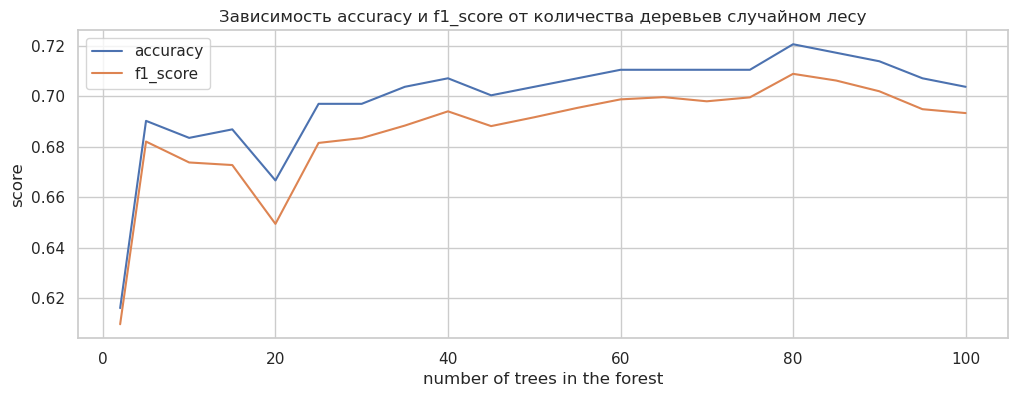

In [116]:
plt.figure(figsize=(12,4))
plt.plot(n_estimators, bag_3_acc, label='accuracy')
plt.plot(n_estimators, bag_3_f1, label='f1_score')


plt.title("Зависимость accuracy и f1_score от количества деревьев случайном лесу")
plt.xlabel("number of trees in the forest")
plt.ylabel("score")
plt.legend(loc='best')
plt.show()

**What is the optimal number of trees you've got? Is it different from the optimal number of logistic regressions/decision trees in 2.6? Explain the results briefly.**

Оптимальное количество деревьев 45, так как получаем при этом значении лучшие метрики качества.

В целом тоже как и в случае с бэггингом наблюдается рост обобщающей способности алгоритма с увеличением количества деревьев, хотя разброс значение больше, нежели при бэггинге.

#### 2.8. Learning curve
Your goal is to estimate, how does the model behaviour change with the increase of the `train` dataset size.

* Split the training data into 10 equal (almost) parts. Then train the models from above (Logistic regression, Desicion Tree, Random Forest) with optimal hyperparameters you have selected on 1 part, 2 parts (combined, so the train size in increased by 2 times), 3 parts and so on.

* Build a plot of `accuracy` and `f1` scores on `test` part, varying the `train` dataset size (so the axes will be score - dataset size.

* Analyse the final plot. Can you make any conlusions using it?

In [117]:
data = []
target = []
target.extend((np.array_split(y_train, 10)))
data.extend((np.array_split(scaled_X_train, 10)))

In [118]:
reg_params

{'C': 59.86584841970366, 'penalty': 'l2'}

In [119]:
forest_params = {'max_depth': 19, 'n_estimators': 45}

In [120]:
# warnings.simplefilter(action='ignore', category=Warning)
forest_1 = RandomForestClassifier(random_state=SEED)
forest_1.set_params(**forest_params)

tree = DecisionTreeClassifier(random_state=SEED)
tree.set_params(**model_2['model'].best_params_)

logistic = LogisticRegression(
                            solver = 'saga',
                            multi_class = 'multinomial',
                            tol=1e-3,
                            max_iter=500
)
logistic.set_params(**reg_params)

def score_return(model, data, target):
    new_data = []
    new_target = []
    acc = []
    f1 = []
    for x_small, y_small in zip(data, target):

        new_data.extend(x_small)
        new_target.extend(y_small)
        model.fit(new_data, new_target)
        y_pred_small = model.predict(scaled_X_test)
        acc.append(accuracy_score(y_test, y_pred_small))
        f1.append(f1_score(y_test, y_pred_small, average = "weighted"))
    return acc, f1

acc_fr, f1_fr = score_return(forest_1, data, target)
acc_tr, f1_tr = score_return(tree, data, target)
acc_lr, f1_lr = score_return(logistic, data, target)


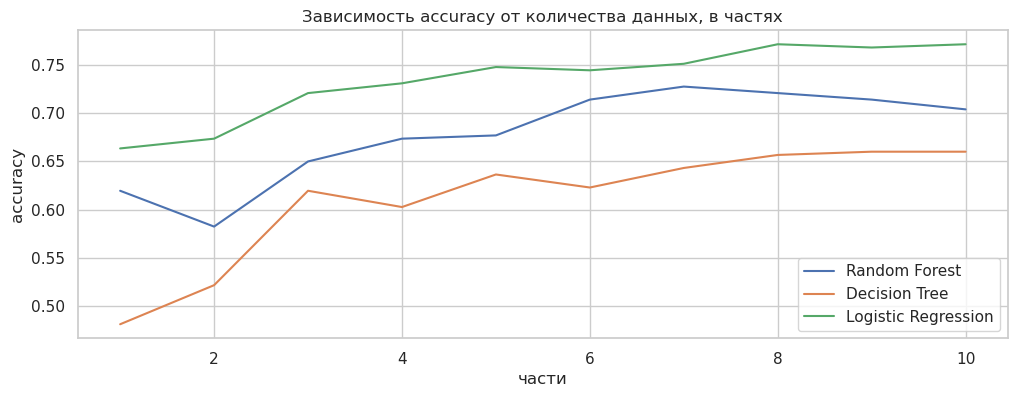

In [121]:
plt.figure(figsize=(12,4))
plt.plot([*range(1, 11)], acc_fr, label='Random Forest')
plt.plot([*range(1, 11)], acc_tr, label='Decision Tree')
plt.plot([*range(1, 11)], acc_lr, label='Logistic Regression')

plt.title("Зависимость accuracy от количества данных, в частях")
plt.xlabel("части")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

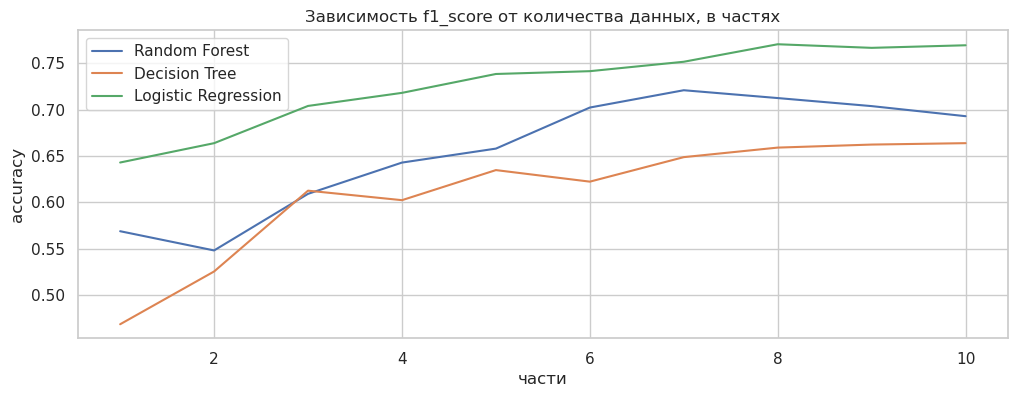

In [122]:
plt.figure(figsize=(12,4))
plt.plot([*range(1, 11)], f1_fr, label='Random Forest')
plt.plot([*range(1, 11)], f1_tr, label='Decision Tree')
plt.plot([*range(1, 11)], f1_lr, label='Logistic Regression')

plt.title("Зависимость f1_score от количества данных, в частях")
plt.xlabel("части")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()

**Analyse the final plot. Can you make any conlusions using it?**

Видно, что с увеличением количества данных генерализующая способность алгоритмов возрастает.

Логистическая регресиия и случайный лес дают обладают более высокой предсказательной способностью нежели дерево решений.

#### 2.9. Boosting
Your goal is to build a boosting ensemble using xgboost, CatBoost or lightgbm package.
Please, do not use the sklearn API for these models.

Find optimal number of decision trees in the boosting ensembe using grid search or other methods.
Please, explain your answer.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    'iterations': [200, 300, 350, 400],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 7, 10, 15]
}



rand_search = RandomizedSearchCV(estimator=ctb.CatBoostClassifier(random_state=42, verbose=0), param_distributions=param_distributions, cv=5, n_jobs=-1, verbose=1)

rand_search.fit(X_train, y_train)
best_catboost_model = rand_search.best_estimator_

y_pred = best_catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of CatBoost: {accuracy:.2f}')
print("Лучшие параметры: ", rand_search.best_params_ )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [25]:
import optuna
# import catboost as ctb
# from sklearn.metrics import accuracy_score

# Функция, которая будет оценивать модель на основе выбранных гиперпараметров
def objective(trial):
    # Определение пространства поиска гиперпараметров через Optuna
    iterations = trial.suggest_categorical('iterations', [200, 300, 350, 400])
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    depth = trial.suggest_categorical('depth', [4, 7, 10])

    # Создание модели CatBoost с выбранными гиперпараметрами
    model = ctb.CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        random_state=42,
        verbose=0
    )
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)
    
    # Вычисление accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Optuna стремится минимизировать целевую функцию, поэтому возвращаем -accuracy
    return accuracy

# Создание объекта Optuna Study для поиска оптимальных гиперпараметров
study = optuna.create_study(direction="maximize")  # Мы максимизируем accuracy
study.optimize(objective, n_trials=50)

# Получение лучших гиперпараметров
best_params = study.best_params

# Обучаем модель с лучшими найденными параметрами
best_model = ctb.CatBoostClassifier(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    random_state=42,
    verbose=0
)

best_model.fit(X_train, y_train)

# Предсказания и оценка
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of CatBoost: {accuracy:.2f}')
print("Лучшие параметры: ", best_params)


[I 2024-10-23 08:36:05,681] A new study created in memory with name: no-name-79f7e1c3-dc77-44e2-9862-57c5a6675b7c
[I 2024-10-23 08:36:13,861] Trial 0 finished with value: 0.7474747474747475 and parameters: {'iterations': 400, 'learning_rate': 0.422254944890807, 'depth': 10}. Best is trial 0 with value: 0.7474747474747475.
[I 2024-10-23 08:36:14,099] Trial 1 finished with value: 0.7542087542087542 and parameters: {'iterations': 400, 'learning_rate': 0.45951583720826095, 'depth': 4}. Best is trial 1 with value: 0.7542087542087542.
[I 2024-10-23 08:36:20,215] Trial 2 finished with value: 0.7272727272727273 and parameters: {'iterations': 300, 'learning_rate': 0.16703673856319132, 'depth': 10}. Best is trial 1 with value: 0.7542087542087542.
[I 2024-10-23 08:36:24,314] Trial 3 finished with value: 0.7441077441077442 and parameters: {'iterations': 200, 'learning_rate': 0.24007354799451255, 'depth': 10}. Best is trial 1 with value: 0.7542087542087542.
[I 2024-10-23 08:36:24,483] Trial 4 finis

Accuracy of CatBoost: 0.79
Лучшие параметры:  {'iterations': 350, 'learning_rate': 0.35435814730270226, 'depth': 4}


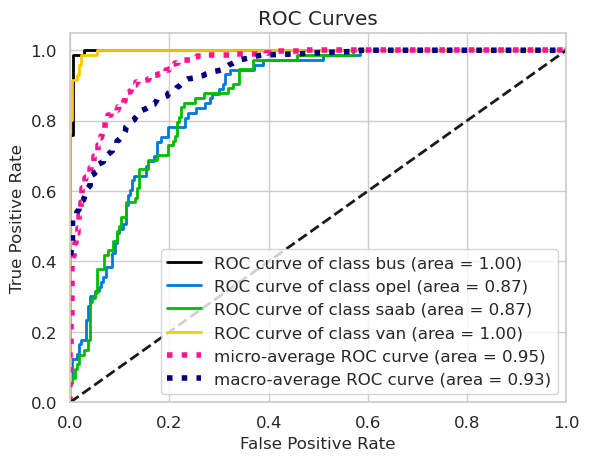

In [26]:
scikitplot.metrics.plot_roc(y_test, best_model.predict_proba(X_test))
plt.show()


In [29]:
n_estimators = [2,*range(5, 1000, 25)]
boost_acc = []
boost_f1 = []
for i in n_estimators:
    catboost = ctb.CatBoostClassifier(random_state=SEED, iterations=i, verbose=0, depth=4, learning_rate=0.3)
    catboost.fit(scaled_X_train, y_train)
    # param_distributions = {
    #     'depth': [4, 8],
    #     'learning_rate': [0.2, 0.3, 0.4],
    #     }
    # iter_cat = RandomizedSearchCV(catboost, param_distributions, random_state = SEED, n_jobs=-1, cv=3, scoring = 'accuracy')

    # iter_cat.fit(scaled_X_train, y_train)
    # y_pred = iter_cat.predict(scaled_X_test)
    y_pred = catboost.predict(scaled_X_test)
    boost_acc.append(accuracy_score(y_test, y_pred))
    boost_f1.append(f1_score(y_test, y_pred, average = "weighted"))


In [32]:
n_estimators = [2,*range(5, 1000, 25)]
boost_acc = []
boost_f1 = []
for i in n_estimators:
    catboost = ctb.CatBoostClassifier(random_state=SEED, iterations=i, verbose=0, learning_rate=0.3)
    # catboost.fit(scaled_X_train, y_train)
    param_distributions = {
        'depth': [4, 5, 6, 7 ],
        'learning_rate': [0.2, 0.3, 0.4],
        }
    iter_cat = RandomizedSearchCV(catboost, param_distributions, random_state = SEED, n_jobs=-1, cv=3, scoring = 'accuracy')

    iter_cat.fit(scaled_X_train, y_train)
    y_pred = iter_cat.predict(scaled_X_test)
    # y_pred = catboost.predict(scaled_X_test)
    boost_acc.append(accuracy_score(y_test, y_pred))
    boost_f1.append(f1_score(y_test, y_pred, average = "weighted"))

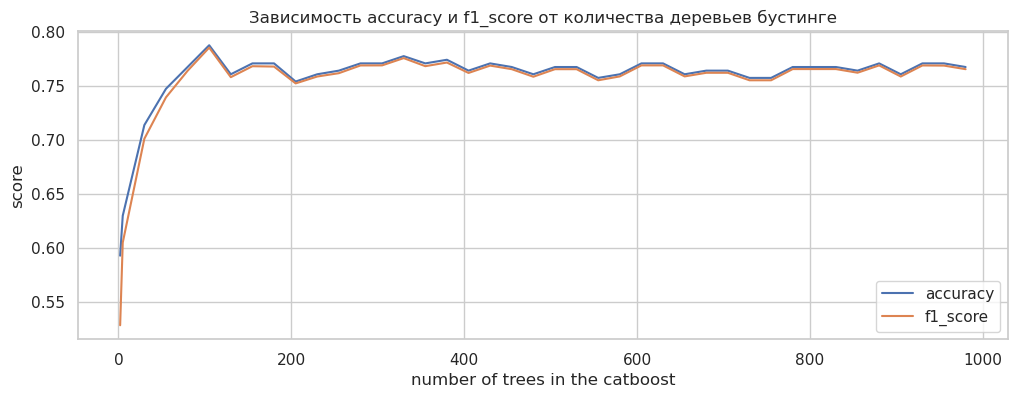

In [30]:
plt.figure(figsize=(12,4))
plt.plot(n_estimators, boost_acc, label='accuracy')
plt.plot(n_estimators, boost_f1, label='f1_score')


plt.title("Зависимость accuracy и f1_score от количества деревьев бустинге")
plt.xlabel("number of trees in the catboost")
plt.ylabel("score")
plt.legend(loc='best')
plt.show()

### Вывод по Boosting
На первых этапах (до 200 деревьев) модель активно учится и качество растет. Но после 200-300 деревьев начинается переобучение: 

модель начинает запоминать шум, что ухудшает результаты на новых данных. Далее, модель уже захватила основные паттерны, 

и добавление деревьев улучшает качество всё меньше. После 600 деревьев модель достигает своего предела, 

и новые деревья не дают значимого улучшения, только увеличивая сложность.